In [1]:
# filter some warning messages
import warnings
warnings.filterwarnings("ignore")

In [2]:
from myfunctions import *

In [3]:
import numpy as np
import xarray as xr
import pandas as pd

import os
import pickle

In [4]:
datapd = pd.read_csv('List_model.csv')

In [5]:
import matplotlib.pyplot as plt
import matplotlib.path as mpath
from matplotlib import cm
from matplotlib.patches import Rectangle
from matplotlib.ticker import FuncFormatter

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import cmocean

from adjustText import adjust_text

In [6]:
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)

In [7]:
# new color from https://colorbrewer2.org/
colors = ['#8dd3c7','#ffffb3','#bebada','#fb8072','#d9d9d9','#fdb462','#fccde5','#b3de69','#80b1d3','#bc80bd','#ccebc5']
# colors = cm.get_cmap("Set3").colors
types = datapd['type'].unique()
color_dict = {}
if len(colors) >= len(types):
    print('create new color dict')
    for i in range(len(types)):
        color_dict[types[i]] = colors[i] #lighten_color(colors[i], 0.6)

create new color dict


In [9]:
def newxy_fmissingxy(dx, dy):
    dx = dx.where((dx>-361) & (dx<361))
    dy = dy.where((dy>-91) & (dy<91))
    newx0 = dx[~np.isnan(dx).any(axis=1)][0]
    newy0 = dy[:, ~np.isnan(dy).any(axis=0)][:,0]
    newx, newy = np.meshgrid(newx0, newy0)
    x = np.where(np.isnan(dx), newx, dx)
    y = np.where(np.isnan(dy), newy, dy)
    return x, y

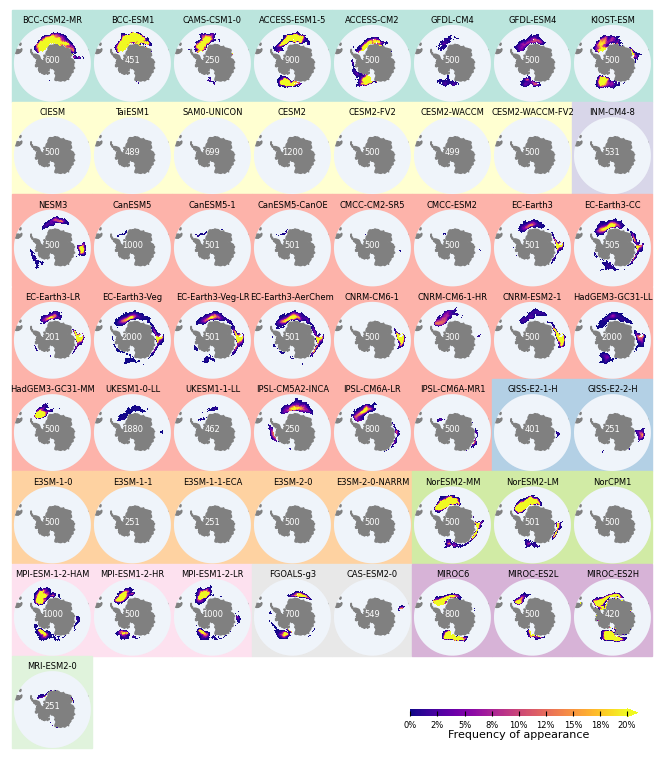

In [36]:
fig = plt.figure(figsize=(6.5, 7.5))
n = 0
for i in range(0, len(datapd)):
    name = datapd.at[i, 'source_id']
    pltd_name = '../../SO_data/data_polynya/' + name + '_mean.pickle'

    fpathst = '../../SO_data/data_mlotst/' + name + '.pickle'
    if os.path.exists(pltd_name):
        n = n + 1
        if not os.path.exists(fpathst):
            ## if no mlotst, use mld calculated by me
            fpathst = '../../SO_data/data_mld/' + name + '.pickle'     
        ds = pd.read_pickle(fpathst)
        
        if not pd.isna(datapd.at[i, 'latname']) and (name != 'CAS-ESM2-0'):
            dlat = ds[datapd.at[i, 'latname']].load()
            dlon = ds[datapd.at[i, 'lonname']].load()
            dlat = dlat.where(dlat <= 90).where(dlat>=-90)
            dlon = dlon.where(dlon <= 360).where(dlon>=-360)
            pltx = dlon
            plty = dlat
            if np.isnan(dlat).any() or np.isnan(dlon).any():
                pltx, plty = newxy_fmissingxy(dlon, dlat)
        else:
            if name == 'CAS-ESM2-0':
                yname = 'lat'
                xname = 'lon'
            else:
                xname = datapd.at[i, 'xname']
                yname = datapd.at[i, 'yname']
            dx = ds[xname]
            dy = ds[yname]
            pltx, plty = np.meshgrid(dx, dy)

        ax = fig.add_subplot(8, 8, n, projection=ccrs.SouthPolarStereo())
        plt.subplots_adjust(left=0.01,
                            bottom=0.01, 
                            right=0.99, 
                            top=0.99, 
                            wspace=0.04, 
                            hspace=0.04)
        bbox = ax.get_position()
        t = datapd.at[i, 'type']
        rect = Rectangle((bbox.x0-0.002367,bbox.y0),
                         bbox.width+0.004734,bbox.height+0.02, 
                         fill=True, color=color_dict[t], alpha=1, zorder=-1,
                         transform=fig.transFigure, clip_on=False)
        fig.add_artist(rect)

        ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
        mld = ds

        pltm = xr.where(mld>=2000, 1, np.nan)
        pltf = pltm.sum('time')/len(pltm.time)
        pltf = pltf.where(pltf>0)
            
        ax.set_title('{}'.format(name), fontsize=6, pad=-0.5)
        ax.text(0,-90, str(len(ds.time)), fontsize=6, color='w', ha='center')

        ax.add_feature(cfeature.LAND, zorder=1, color = 'grey')
        ax.add_feature(cfeature.OCEAN, alpha = 0.15)
        ax.set_boundary(circle, transform=ax.transAxes)

        ax.spines['geo'].set_edgecolor(None)
        im2 = ax.pcolormesh(pltx, plty, pltf, vmin = 0, vmax=0.2, 
                           transform=ccrs.PlateCarree(), cmap=plt.cm.plasma)

# cbar_ax2 = fig.add_axes([0.20, 0.07, 0.35, 0.01])
# cbar2 = fig.colorbar(im2, cax=cbar_ax2, orientation='horizontal', extend='max', drawedges=False)
# cbar2.set_label('Frequency of appearance', size=8, labelpad=-0.1)
# cbar2.ax.tick_params(labelsize=6, direction='in')



cbar_ax2 = fig.add_axes([0.62, 0.06, 0.35, 0.01])
cbar2 = fig.colorbar(im2, cax=cbar_ax2, 
                     orientation='horizontal', 
                     extend='max')
cbar2.set_label('Frequency of appearance', size=8, labelpad=-0.1)
cbar2.ax.tick_params(labelsize=6, direction='in')
cbar2.outline.set_visible(False)
def to_percentage(x, pos):
    return f"{x * 100:.0f}%"

cbar2.formatter = FuncFormatter(to_percentage)
cbar2.update_ticks()

fig.savefig('DeepConvection_Multi.png', dpi = 300)
# fig.savefig('DeepConvection_Multi.eps', format='eps')  # too big (should be less than 5MB
# fig.savefig('DeepConvection_Multi.pdf', format='pdf')  # too big (should be less than 5MB

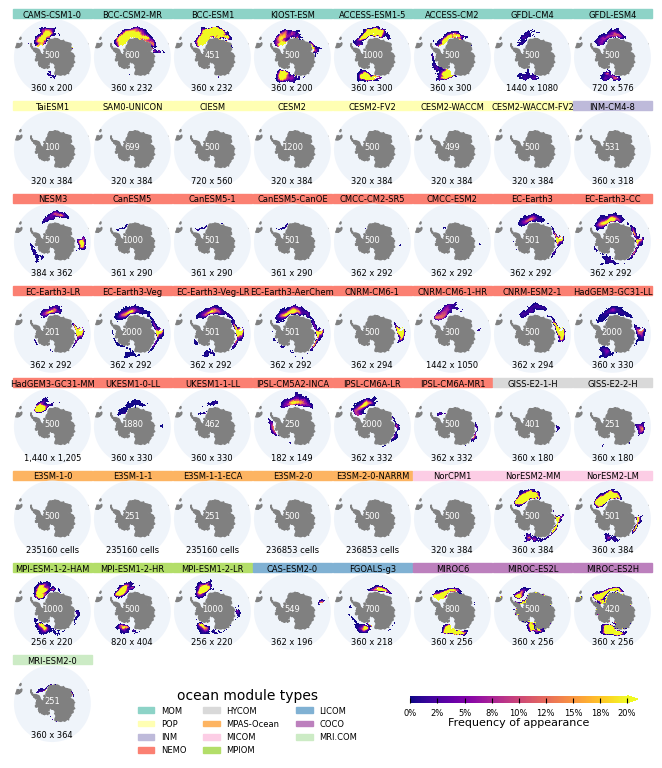

In [24]:
fig = plt.figure(figsize=(6.5, 7.5))
n = 0
for i in range(0, len(datapd)):
    name = datapd.at[i, 'source_id']

    fpathst = '../../SO_data/data_mlotst/' + name + '.pickle'
    varname = 'mlotst'
    n = n + 1

    if not os.path.exists(fpathst):
        ## if no mlotst, use mld calculated by me
        fpathst = '../../SO_data/data_mld/' + name + '.pickle'     
        varname = 'mld'
    ds_all = pd.read_pickle(fpathst)
    

    ds = ds_all[varname]

    if name == 'TaiESM1':
        ds = ds.isel(time = slice(-100, None))
    
    if not pd.isna(datapd.at[i, 'latname']) and (name != 'CAS-ESM2-0'):
        dlat = ds[datapd.at[i, 'latname']].load()
        dlon = ds[datapd.at[i, 'lonname']].load()
        dlat = dlat.where(dlat <= 90).where(dlat>=-90)
        dlon = dlon.where(dlon <= 360).where(dlon>=-360)
        pltx = dlon
        plty = dlat
        if np.isnan(dlat).any() or np.isnan(dlon).any():
            pltx, plty = newxy_fmissingxy(dlon, dlat)
    else:
        if name == 'CAS-ESM2-0':
            yname = 'lat'
            xname = 'lon'
        else:
            xname = datapd.at[i, 'xname']
            yname = datapd.at[i, 'yname']
        dx = ds[xname]
        dy = ds[yname]
        pltx, plty = np.meshgrid(dx, dy)

    ax = fig.add_subplot(8, 8, n, projection=ccrs.SouthPolarStereo())
    plt.subplots_adjust(left=0.01,
                        bottom=0.01, 
                        right=0.99, 
                        top=0.99, 
                        wspace=0.04, 
                        hspace=0.04)
    bbox = ax.get_position()
    t = datapd.at[i, 'type']
    rect = Rectangle((bbox.x0-0.002,bbox.y1+0.001),
                     bbox.width+0.004, 0.012, 
                     fill=True, color=color_dict[t], alpha=1, zorder=-1,
                     transform=fig.transFigure, clip_on=False)
    fig.add_artist(rect)

    ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
    mld = ds

    pltm = xr.where(mld>=2000, 1, np.nan)
    pltf = pltm.sum('time')/len(pltm.time)
    pltf = pltf.where(pltf>0)
        
    title = ax.set_title('{}'.format(name), 
                         fontsize=6, pad=-0.5)
    # title._bbox_patch._mutation_aspect = 1
    # title.get_bbox_patch().set_boxstyle("square", pad=11.9)
    ax.text(0,-90, str(len(ds.time)), fontsize=6, color='w', ha='center')
    ax.text(180,-55, str(datapd.at[i, 'resolution']), transform=ccrs.PlateCarree(), fontsize=6, color='k', ha='center')

    ax.add_feature(cfeature.LAND, zorder=1, color = 'grey')
    ax.add_feature(cfeature.OCEAN, alpha = 0.15)
    ax.set_boundary(circle, transform=ax.transAxes)

    ax.spines['geo'].set_edgecolor(None)
    im2 = ax.pcolormesh(pltx, plty, pltf, vmin = 0, vmax=0.2, 
                       transform=ccrs.PlateCarree(), cmap=plt.cm.plasma)

proxy_artists = [Rectangle((0,0),1,1, color = c) for c in colors]
fig.legend(proxy_artists, types, 
           title = 'ocean module types',
           frameon = False,
           bbox_to_anchor=(0.55, 0.10),
           ncols=3, fontsize = 6)

# cbar_ax2 = fig.add_axes([0.20, 0.07, 0.35, 0.01])
# cbar2 = fig.colorbar(im2, cax=cbar_ax2, orientation='horizontal', extend='max', drawedges=False)
# cbar2.set_label('Frequency of appearance', size=8, labelpad=-0.1)
# cbar2.ax.tick_params(labelsize=6, direction='in')

cbar_ax2 = fig.add_axes([0.62, 0.07, 0.35, 0.01])
cbar2 = fig.colorbar(im2, cax=cbar_ax2, 
                     orientation='horizontal', 
                     extend='max')
cbar2.set_label('Frequency of appearance', size=8, labelpad=-0.1)
cbar2.ax.tick_params(labelsize=6, direction='in')
cbar2.outline.set_visible(False)
def to_percentage(x, pos):
    return f"{x * 100:.0f}%"

cbar2.formatter = FuncFormatter(to_percentage)
cbar2.update_ticks()


fig.savefig('DeepConvection_Multi_title.png', dpi = 300)
# fig.savefig('DeepConvection_Multi.eps', format='eps')  # too big (should be less than 5MB
# fig.savefig('DeepConvection_Multi.pdf', format='pdf')  # too big (should be less than 5MB

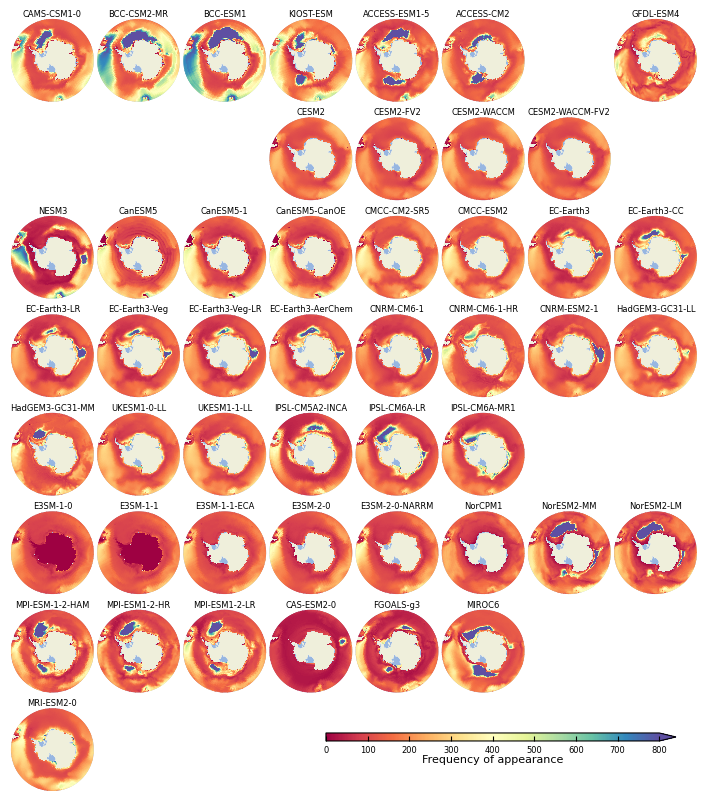

In [39]:
fig = plt.figure(figsize=(7, 8))

n = 0

# newcmap = cmocean.tools.crop_by_percent(cmocean.cm.matter, 20, which='min', N=None)
for i in range(0, len(datapd)):
    name = datapd.at[i, 'source_id']
    # pltd_dict = {'pltd':pltd, 'pld_pc':pltd_pc,'pltx':pltx, 'plty':plty}

    


    fpathst = '../../SO_data/data_mlotst/' + name + '.pickle'

    
    n = n + 1
    if not os.path.exists(fpathst):
        continue
        
    ds = pd.read_pickle(fpathst)
    
    if not pd.isna(datapd.at[i, 'latname']) and (name != 'CAS-ESM2-0'):
        dlat = ds[datapd.at[i, 'latname']].load()
        dlon = ds[datapd.at[i, 'lonname']].load()
        dlat = dlat.where(dlat <= 90).where(dlat>=-90)
        dlon = dlon.where(dlon <= 360).where(dlon>=-360)
        pltx = dlon
        plty = dlat
        if np.isnan(dlat).any() or np.isnan(dlon).any():
            pltx, plty = newxy_fmissingxy(dlon, dlat)

    else:
        if name == 'CAS-ESM2-0':
            yname = 'lat'
            xname = 'lon'
        else:
            xname = datapd.at[i, 'xname']
            yname = datapd.at[i, 'yname']
        dx = ds[xname]
        dy = ds[yname]
        pltx, plty = np.meshgrid(dx, dy)

    
    ax = fig.add_subplot(8, 8, n, projection=ccrs.SouthPolarStereo())
    plt.subplots_adjust(left=0.01,
                        bottom=0.01, 
                        right=0.99, 
                        top=0.99, 
                        wspace=0.04, 
                        hspace=0.04)
    # fig.subplots_adjust(wspace=0.04, hspace=0.12)
    ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
    mld = ds.mlotst

    pltm = xr.where(mld>=2000, 1, np.nan)
    pltf = pltm.sum('time')/len(pltm.time)
    pltf = pltf.where(pltf>0)
    pltf = mld.mean('time')


    # gl = ax.gridlines(
    #     xlocs = np.arange(-180,180,90), 
    #     ylocs = np.arange(-90,90,20),
    #     draw_labels=False, y_inline=True)
        
    ax.set_title('{}'.format(name), fontsize=6, pad=-0.5)
    

    # im = ax.pcolormesh(pltx, plty, pltm, vmin = 0, vmax=1.2, 
    #                    transform=ccrs.PlateCarree(), cmap=plt.cm.gray)
    ax.add_feature(cfeature.LAND, zorder=1)
    ax.add_feature(cfeature.OCEAN)
    ax.set_boundary(circle, transform=ax.transAxes)
    # ax.outline_patch.set_visible(False)
    # ax.outline_patch.set_edgecolor('white')
    ax.spines['geo'].set_edgecolor(None)
    im2 = ax.pcolormesh(pltx, plty, pltf, vmin = 0, vmax=800, 
                       transform=ccrs.PlateCarree(), cmap=plt.cm.Spectral)
    # cbar = plt.colorbar(im) 

    
    # newcmap = cmocean.tools.crop_by_percent(cmocean.cm.speed_r, 50, which='min', N=None)
    # im2 = ax.pcolormesh(pltx, plty, pltd_pc, 
    #                     transform=ccrs.PlateCarree(), 
    #                     vmin = 0, vmax = 0.20, cmap=plt.cm.Spectral)
    # ax.add_feature(cfeature.LAND, zorder=1)#, color='0.8')
    # ax.add_feature(cfeature.COASTLINE, linewidth=0.2)
    # ax.set_boundary(circle, transform=ax.transAxes)

    # if n > 3:
    #     break 


# cbar_ax1 = fig.add_axes([0.46, 0.11, 0.50, 0.01])
# cbar1 = fig.colorbar(im, cax=cbar_ax1, orientation='horizontal')
# cbar1.set_label('Maximum sea ice coverage (%)', size=8, labelpad=-0.1)
# cbar1.ax.tick_params(labelsize=6,direction='in')

cbar_ax2 = fig.add_axes([0.46, 0.08, 0.50, 0.01])
cbar2 = fig.colorbar(im2, cax=cbar_ax2, orientation='horizontal', extend='max')
cbar2.set_label('Frequency of appearance', size=8, labelpad=-0.1)
cbar2.ax.tick_params(labelsize=6,direction='in')

# fig.savefig('DeepConvection_Multi.png', dpi = 300)


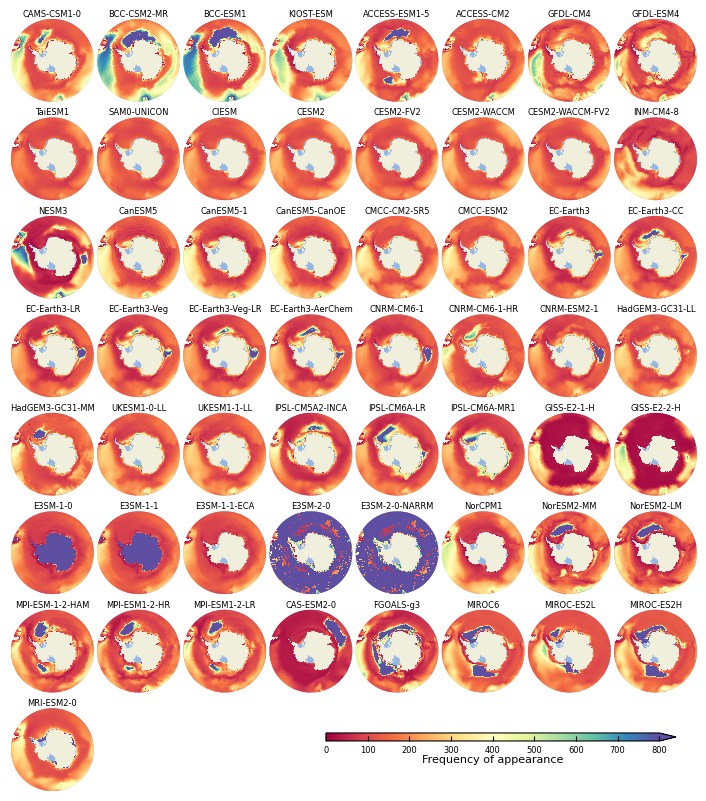

In [18]:
fig = plt.figure(figsize=(7, 8))

n = 0

# newcmap = cmocean.tools.crop_by_percent(cmocean.cm.matter, 20, which='min', N=None)
for i in range(0, len(datapd)):
    name = datapd.at[i, 'source_id']
    # pltd_dict = {'pltd':pltd, 'pld_pc':pltd_pc,'pltx':pltx, 'plty':plty}

    # pltd_name = '../../SO_data/data_polynya/' + name + '_mean.pickle'


    fpathst = '../../SO_data/data_mld/' + name + '.pickle'

    
    n = n + 1
    if not os.path.exists(fpathst):
        continue
        
    ds = pd.read_pickle(fpathst)
    
    if not pd.isna(datapd.at[i, 'latname']) and (name != 'CAS-ESM2-0'):
        dlat = ds[datapd.at[i, 'latname']].load()
        dlon = ds[datapd.at[i, 'lonname']].load()
        dlat = dlat.where(dlat <= 90).where(dlat>=-90)
        dlon = dlon.where(dlon <= 360).where(dlon>=-360)
        pltx = dlon
        plty = dlat
        if np.isnan(dlat).any() or np.isnan(dlon).any():
            pltx, plty = newxy_fmissingxy(dlon, dlat)

    else:
        if name == 'CAS-ESM2-0':
            yname = 'lat'
            xname = 'lon'
        else:
            xname = datapd.at[i, 'xname']
            yname = datapd.at[i, 'yname']
        dx = ds[xname]
        dy = ds[yname]
        pltx, plty = np.meshgrid(dx, dy)

    
    ax = fig.add_subplot(8, 8, n, projection=ccrs.SouthPolarStereo())
    plt.subplots_adjust(left=0.01,
                        bottom=0.01, 
                        right=0.99, 
                        top=0.99, 
                        wspace=0.04, 
                        hspace=0.04)
    # fig.subplots_adjust(wspace=0.04, hspace=0.12)
    ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
    mld = ds.mld

    pltm = xr.where(mld>=2000, 1, np.nan)
    pltf = pltm.sum('time')/len(pltm.time)
    pltf = pltf.where(pltf>0)
    pltf = mld.mean('time')


    # gl = ax.gridlines(
    #     xlocs = np.arange(-180,180,90), 
    #     ylocs = np.arange(-90,90,20),
    #     draw_labels=False, y_inline=True)
        
    ax.set_title('{}'.format(name), fontsize=6, pad=-0.5)
    

    # im = ax.pcolormesh(pltx, plty, pltm, vmin = 0, vmax=1.2, 
    #                    transform=ccrs.PlateCarree(), cmap=plt.cm.gray)
    ax.add_feature(cfeature.LAND, zorder=1)
    ax.add_feature(cfeature.OCEAN)
    ax.set_boundary(circle, transform=ax.transAxes)
    # ax.outline_patch.set_visible(False)
    # ax.outline_patch.set_edgecolor('white')
    ax.spines['geo'].set_edgecolor(None)
    im2 = ax.pcolormesh(pltx, plty, pltf, vmin = 0, vmax=800, 
                       transform=ccrs.PlateCarree(), cmap=plt.cm.Spectral)
    # cbar = plt.colorbar(im) 

    
    # newcmap = cmocean.tools.crop_by_percent(cmocean.cm.speed_r, 50, which='min', N=None)
    # im2 = ax.pcolormesh(pltx, plty, pltd_pc, 
    #                     transform=ccrs.PlateCarree(), 
    #                     vmin = 0, vmax = 0.20, cmap=plt.cm.Spectral)
    # ax.add_feature(cfeature.LAND, zorder=1)#, color='0.8')
    # ax.add_feature(cfeature.COASTLINE, linewidth=0.2)
    # ax.set_boundary(circle, transform=ax.transAxes)

    # if n > 3:
    #     break 


# cbar_ax1 = fig.add_axes([0.46, 0.11, 0.50, 0.01])
# cbar1 = fig.colorbar(im, cax=cbar_ax1, orientation='horizontal')
# cbar1.set_label('Maximum sea ice coverage (%)', size=8, labelpad=-0.1)
# cbar1.ax.tick_params(labelsize=6,direction='in')

cbar_ax2 = fig.add_axes([0.46, 0.08, 0.50, 0.01])
cbar2 = fig.colorbar(im2, cax=cbar_ax2, orientation='horizontal', extend='max')
cbar2.set_label('Frequency of appearance', size=8, labelpad=-0.1)
cbar2.ax.tick_params(labelsize=6,direction='in')

# fig.savefig('DeepConvection_Multi.png', dpi = 300)


In [11]:
pd.read_pickle('../../SO_data/data_mld/CESM2-WACCM.pickle')

EOFError: Ran out of input

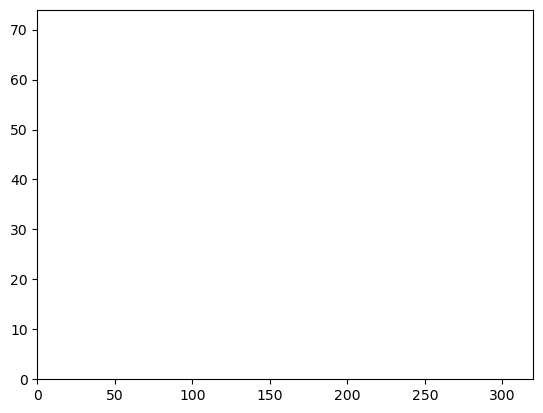

In [44]:
plt.pcolormesh(pd.read_pickle('../../SO_data/data_mld/CESM2-WACCM.pickle').mld.isel(time=0))

In [ ]:
	zstore_so
12	gs://cmip6/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Omon/so/gn/v20190320/

In [ ]:
	zstore_thetao
12	gs://cmip6/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Omon/thetao/gn/v20190320/

In [47]:
dsso = open_from_cloud("gs://cmip6/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Omon/so/gn/v20190320/")
dsthetao = open_from_cloud("gs://cmip6/CMIP6/CMIP/NCAR/CESM2/piControl/r1i1p1f1/Omon/thetao/gn/v20190320/")

In [50]:
dsso.so

<xarray.DataArray 'so' (time: 14400, lev: 60, nlat: 384, nlon: 320)> Size: 425GB
dask.array<open_dataset-so, shape=(14400, 60, 384, 320), dtype=float32, chunksize=(10, 60, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    lat      (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
  * lev      (lev) float64 480B 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    lon      (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
  * nlat     (nlat) int32 2kB 1 2 3 4 5 6 7 8 ... 378 379 380 381 382 383 384
  * nlon     (nlon) int32 1kB 1 2 3 4 5 6 7 8 ... 314 315 316 317 318 319 320
  * time     (time) object 115kB 0001-01-15 13:00:00.999998 ... 1200-12-15 12...
Attributes: (12/19)
    cell_measures:  area: areacello volume: volcello
    cell_methods:   area: mean where sea time: mean
    comment:        Sea water salinity is the salt content of sea water, ofte...
    description:    Sea water salinity is the salt content of sea water, ofte...
    frequency:      mon
    id:             so
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Sea Water Salinity
    type:           real
    units:          0.001
    variable_id:    so

In [51]:
dsthetao.thetao

<xarray.DataArray 'thetao' (time: 14400, lev: 60, nlat: 384, nlon: 320)> Size: 425GB
dask.array<open_dataset-thetao, shape=(14400, 60, 384, 320), dtype=float32, chunksize=(8, 60, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    lat      (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
  * lev      (lev) float64 480B 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
    lon      (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
  * nlat     (nlat) int32 2kB 1 2 3 4 5 6 7 8 ... 378 379 380 381 382 383 384
  * nlon     (nlon) int32 1kB 1 2 3 4 5 6 7 8 ... 314 315 316 317 318 319 320
  * time     (time) object 115kB 0001-01-15 13:00:00.999998 ... 1200-12-15 12...
Attributes: (12/19)
    cell_measures:  area: areacello volume: volcello
    cell_methods:   area: mean where sea time: mean
    comment:        Diagnostic should be contributed even for models using co...
    description:    Diagnostic should be contributed even for models using co...
    frequency:      mon
    id:             thetao
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Sea Water Potential Temperature
    type:           real
    units:          degC
    variable_id:    thetao

In [59]:
levname = 'lev'
dat = check_lev_unit(levname, dsthetao.thetao)
das = check_lev_unit(levname, dsso.so)

In [60]:
dat

<xarray.DataArray 'thetao' (time: 14400, lev: 60, nlat: 384, nlon: 320)> Size: 425GB
dask.array<open_dataset-thetao, shape=(14400, 60, 384, 320), dtype=float32, chunksize=(8, 60, 384, 320), chunktype=numpy.ndarray>
Coordinates:
    lat      (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
    lon      (nlat, nlon) float64 983kB dask.array<chunksize=(384, 320), meta=np.ndarray>
  * nlat     (nlat) int32 2kB 1 2 3 4 5 6 7 8 ... 378 379 380 381 382 383 384
  * nlon     (nlon) int32 1kB 1 2 3 4 5 6 7 8 ... 314 315 316 317 318 319 320
  * time     (time) object 115kB 0001-01-15 13:00:00.999998 ... 1200-12-15 12...
  * lev      (lev) float64 480B 5.0 15.0 25.0 ... 4.875e+03 5.125e+03 5.375e+03
Attributes: (12/19)
    cell_measures:  area: areacello volume: volcello
    cell_methods:   area: mean where sea time: mean
    comment:        Diagnostic should be contributed even for models using co...
    description:    Diagnostic should be contributed even for models using co...
    frequency:      mon
    id:             thetao
    ...             ...
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Sea Water Potential Temperature
    type:           real
    units:          degC
    variable_id:    thetao

In [57]:
if 'units' in dsthetao.thetao[levname].attrs:
    if dsthetao.thetao[levname].attrs['units'] == 'centimeters':
        print('ue')

ue


In [ ]:
dsthetao.thetao[levname].attrs

In [58]:
def check_lev_unit(levname, da):
    # check unit of depth and convert 
    # unit: cm --> m
    if 'units' in da[levname].attrs:
        if da[levname].attrs['units'] == 'centimeters':
            da[levname] = da[levname]/100
    return da